# Análisis de baselines

## 1.- Importación de librerias

In [35]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(".."))
from src.fitness import fitness

BASE_PATH = "../data/memoria"
SOLUTION_PATH = "../datos_sensibles/experiment1/data/memoria"

In [36]:
class Data:
    def __init__(self, students):
        self.students = students
        self.num_slots = students.shape[0]
        self.num_days = students.shape[1]
        self.num_students = students.shape[2]

class Solution:
    def __init__(self, matrix):
        self.matrix = matrix

    def is_assigned(self, slot, day):
        cell = str(self.matrix[slot, day]).strip()
        return cell.isdigit()


## 2.- Funciones

In [37]:
def find_slot_baseline(baseline_path):
    slots = []
    for baseline_file in os.listdir(baseline_path):
        if baseline_file.endswith('.csv'):
            path_baseline = os.path.join(baseline_path, baseline_file)
            schedule = pd.read_csv(path_baseline, header=None).values
            slot = np.argwhere(schedule == 1)
            
            if len(slot) != 1:
                raise ValueError(f"Baseline file {baseline_file} in {baseline_path} has invalid number of slots assigned.")
            slots.append((slot[0][0], slot[0][1]))
    return slots

def find_my_slot(solution_path):
    slots = []
    df = pd.read_csv(solution_path, header=None)
    for i, row in enumerate(df.values):
        for j, c in enumerate(row):
            if c.isdigit():
                slots.append((np.int64(i), np.int64(j)))
    return slots

def evaluate_students(students_path, slots):
    total = 0
    participated = 0
    conflicted = 0
    for student_file in os.listdir(students_path):
        if student_file.endswith('.csv'):
            total += 1
            path_student = os.path.join(students_path, student_file)
            preferences = pd.read_csv(path_student, header=None).values
            values = [preferences[slot[0], slot[1]] for slot in slots]

            if any(v == 0 for v in values):
                participated += 1
            else:
                conflicted += 1
                
    return total, participated, conflicted

In [38]:
def load_students(students_path):
    matrices = []

    for f in os.listdir(students_path):
        if f.endswith(".csv"):
            m = pd.read_csv(os.path.join(students_path, f), header=None).values
            matrices.append(m)

    # stack -> [slot, day, student]
    students = np.stack(matrices, axis=2)
    return Data(students)

def load_solution(path_csv):
    matrix = pd.read_csv(path_csv, header=None).values
    return Solution(matrix)

def load_baseline_solution(baseline_path, num_slots, num_days):
    matrix = np.full((num_slots, num_days), ".", dtype=object)

    slots = find_slot_baseline(baseline_path)
    for slot, day in slots:
        matrix[slot, day] = "1"

    return Solution(matrix)


In [39]:
results = []

for memoria_folder in os.listdir(BASE_PATH):
    path_memoria = os.path.join(BASE_PATH, memoria_folder)
    if not os.path.isdir(path_memoria):
        continue

    baseline_path = os.path.join(path_memoria, "baseline")
    students_path = os.path.join(path_memoria, "students")

    slots = find_slot_baseline(baseline_path)
    total, participated, conflicted = evaluate_students(students_path, slots)
    participation_rate = (participated / total) * 100 if total > 0 else 0
    data = load_students(students_path)

    baseline_solution = load_baseline_solution(
        baseline_path,
        data.num_slots,
        data.num_days
    )

    fitness_value = fitness(baseline_solution, data)

    results.append({
        "Sigla": memoria_folder,
        "Total Estudiantes": total,
        "Participantes": participated,
        "Con conflicto": conflicted,
        "% Participación": round(participation_rate, 2),
        "Fitness Baseline": round(fitness_value, 2),
        "% Fitness": round(fitness_value *100 / total, 2)
    })


In [40]:
df_baseline = pd.DataFrame(results)
df_baseline = df_baseline.sort_values(
    by="% Fitness", ascending=False
)

df_baseline

,Sigla,Total Estudiantes,Participantes,Con conflicto,% Participación,Fitness Baseline,% Fitness
3,INF246,58,58,0,100.00,56.00,96.55
10,INF134,35,35,0,100.00,31.83,90.95
1,INF155,80,79,1,98.75,65.83,82.29
11,INF280,59,59,0,100.00,44.67,75.71
7,INF256,18,16,2,88.89,13.17,73.15
0,INF253,64,57,7,89.06,46.67,72.92
2,INF152,35,29,6,82.86,23.67,67.62
6,INF295,53,46,7,86.79,32.00,60.38
5,INF285,58,55,3,94.83,34.17,58.91
12,INF245,33,33,0,100.00,19.17,58.08


In [41]:
comparison = []

for memoria_folder in os.listdir(BASE_PATH):
    path_memoria = os.path.join(BASE_PATH, memoria_folder)
    if not os.path.isdir(path_memoria):
        continue

    baseline_path = os.path.join(path_memoria, "baseline")
    my_path       = os.path.join(SOLUTION_PATH, memoria_folder, "sa_with_constraints_solution.csv")
    students_path = os.path.join(path_memoria, "students")

    baseline_slots = find_slot_baseline(baseline_path)
    my_slots       = find_my_slot(my_path)

    total_b, participated_b, conflicted_b = evaluate_students(students_path, baseline_slots)
    total_m, participated_m, conflicted_m = evaluate_students(students_path, my_slots)

    fitness_baseline = df_baseline.loc[
        df_baseline["Sigla"] == memoria_folder,
        "Fitness Baseline"
    ].values[0]

    data = load_students(students_path)
    sa_solution = load_solution(my_path)
    fitness_sa = fitness(sa_solution, data)

    comparison.append({
        "Sigla": memoria_folder,
        "Total Estudiantes": total_b,
        #"Participación Baseline": participated_b,
        #"Participación SA": participated_m,
        "Conflictos Baseline": conflicted_b,
        "Conflictos SA": conflicted_m,
        "% Fitness Baseline": round(fitness_baseline *100 / total_b, 2),
        "% Fitness SA": round(fitness_sa *100 / total_b, 2)


    })


In [42]:
df_comparison = pd.DataFrame(comparison)
df_comparison = df_comparison.sort_values(by="% Fitness Baseline", ascending=False)
df_comparison


,Sigla,Total Estudiantes,Conflictos Baseline,Conflictos SA,% Fitness Baseline,% Fitness SA
3,INF246,58,0,3,96.55,89.37
10,INF134,35,0,0,90.94,84.38
1,INF155,80,1,0,82.29,94.00
11,INF280,59,0,0,75.71,83.33
7,INF256,18,2,2,73.17,73.15
0,INF253,64,7,0,72.92,96.88
2,INF152,35,6,7,67.63,69.05
6,INF295,53,7,0,60.38,80.82
5,INF285,58,3,1,58.91,68.10
12,INF245,33,0,0,58.09,82.32


<Figure size 1400x700 with 0 Axes>

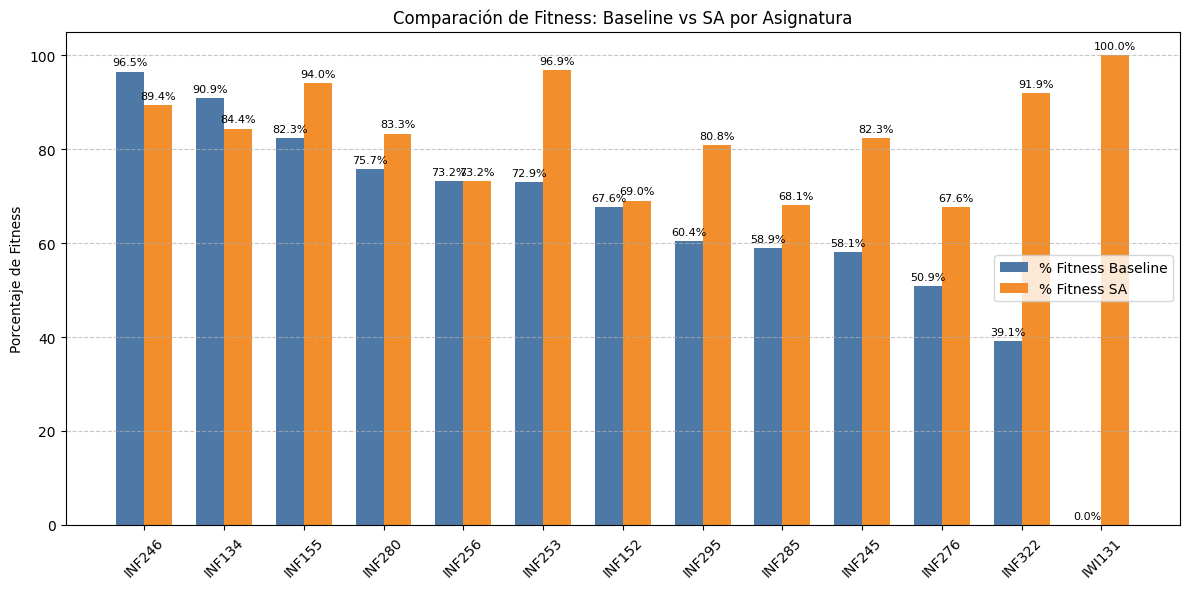

In [43]:
plt.figure(figsize=(14, 7))
x = np.arange(len(df_comparison['Sigla']))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, df_comparison['% Fitness Baseline'], width, label='% Fitness Baseline', color='#4e79a7')
rects2 = ax.bar(x + width/2, df_comparison['% Fitness SA'], width, label='% Fitness SA', color='#f28e2b')

ax.set_ylabel('Porcentaje de Fitness')
ax.set_title('Comparación de Fitness: Baseline vs SA por Asignatura')
ax.set_xticks(x)
ax.set_xticklabels(df_comparison['Sigla'], rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

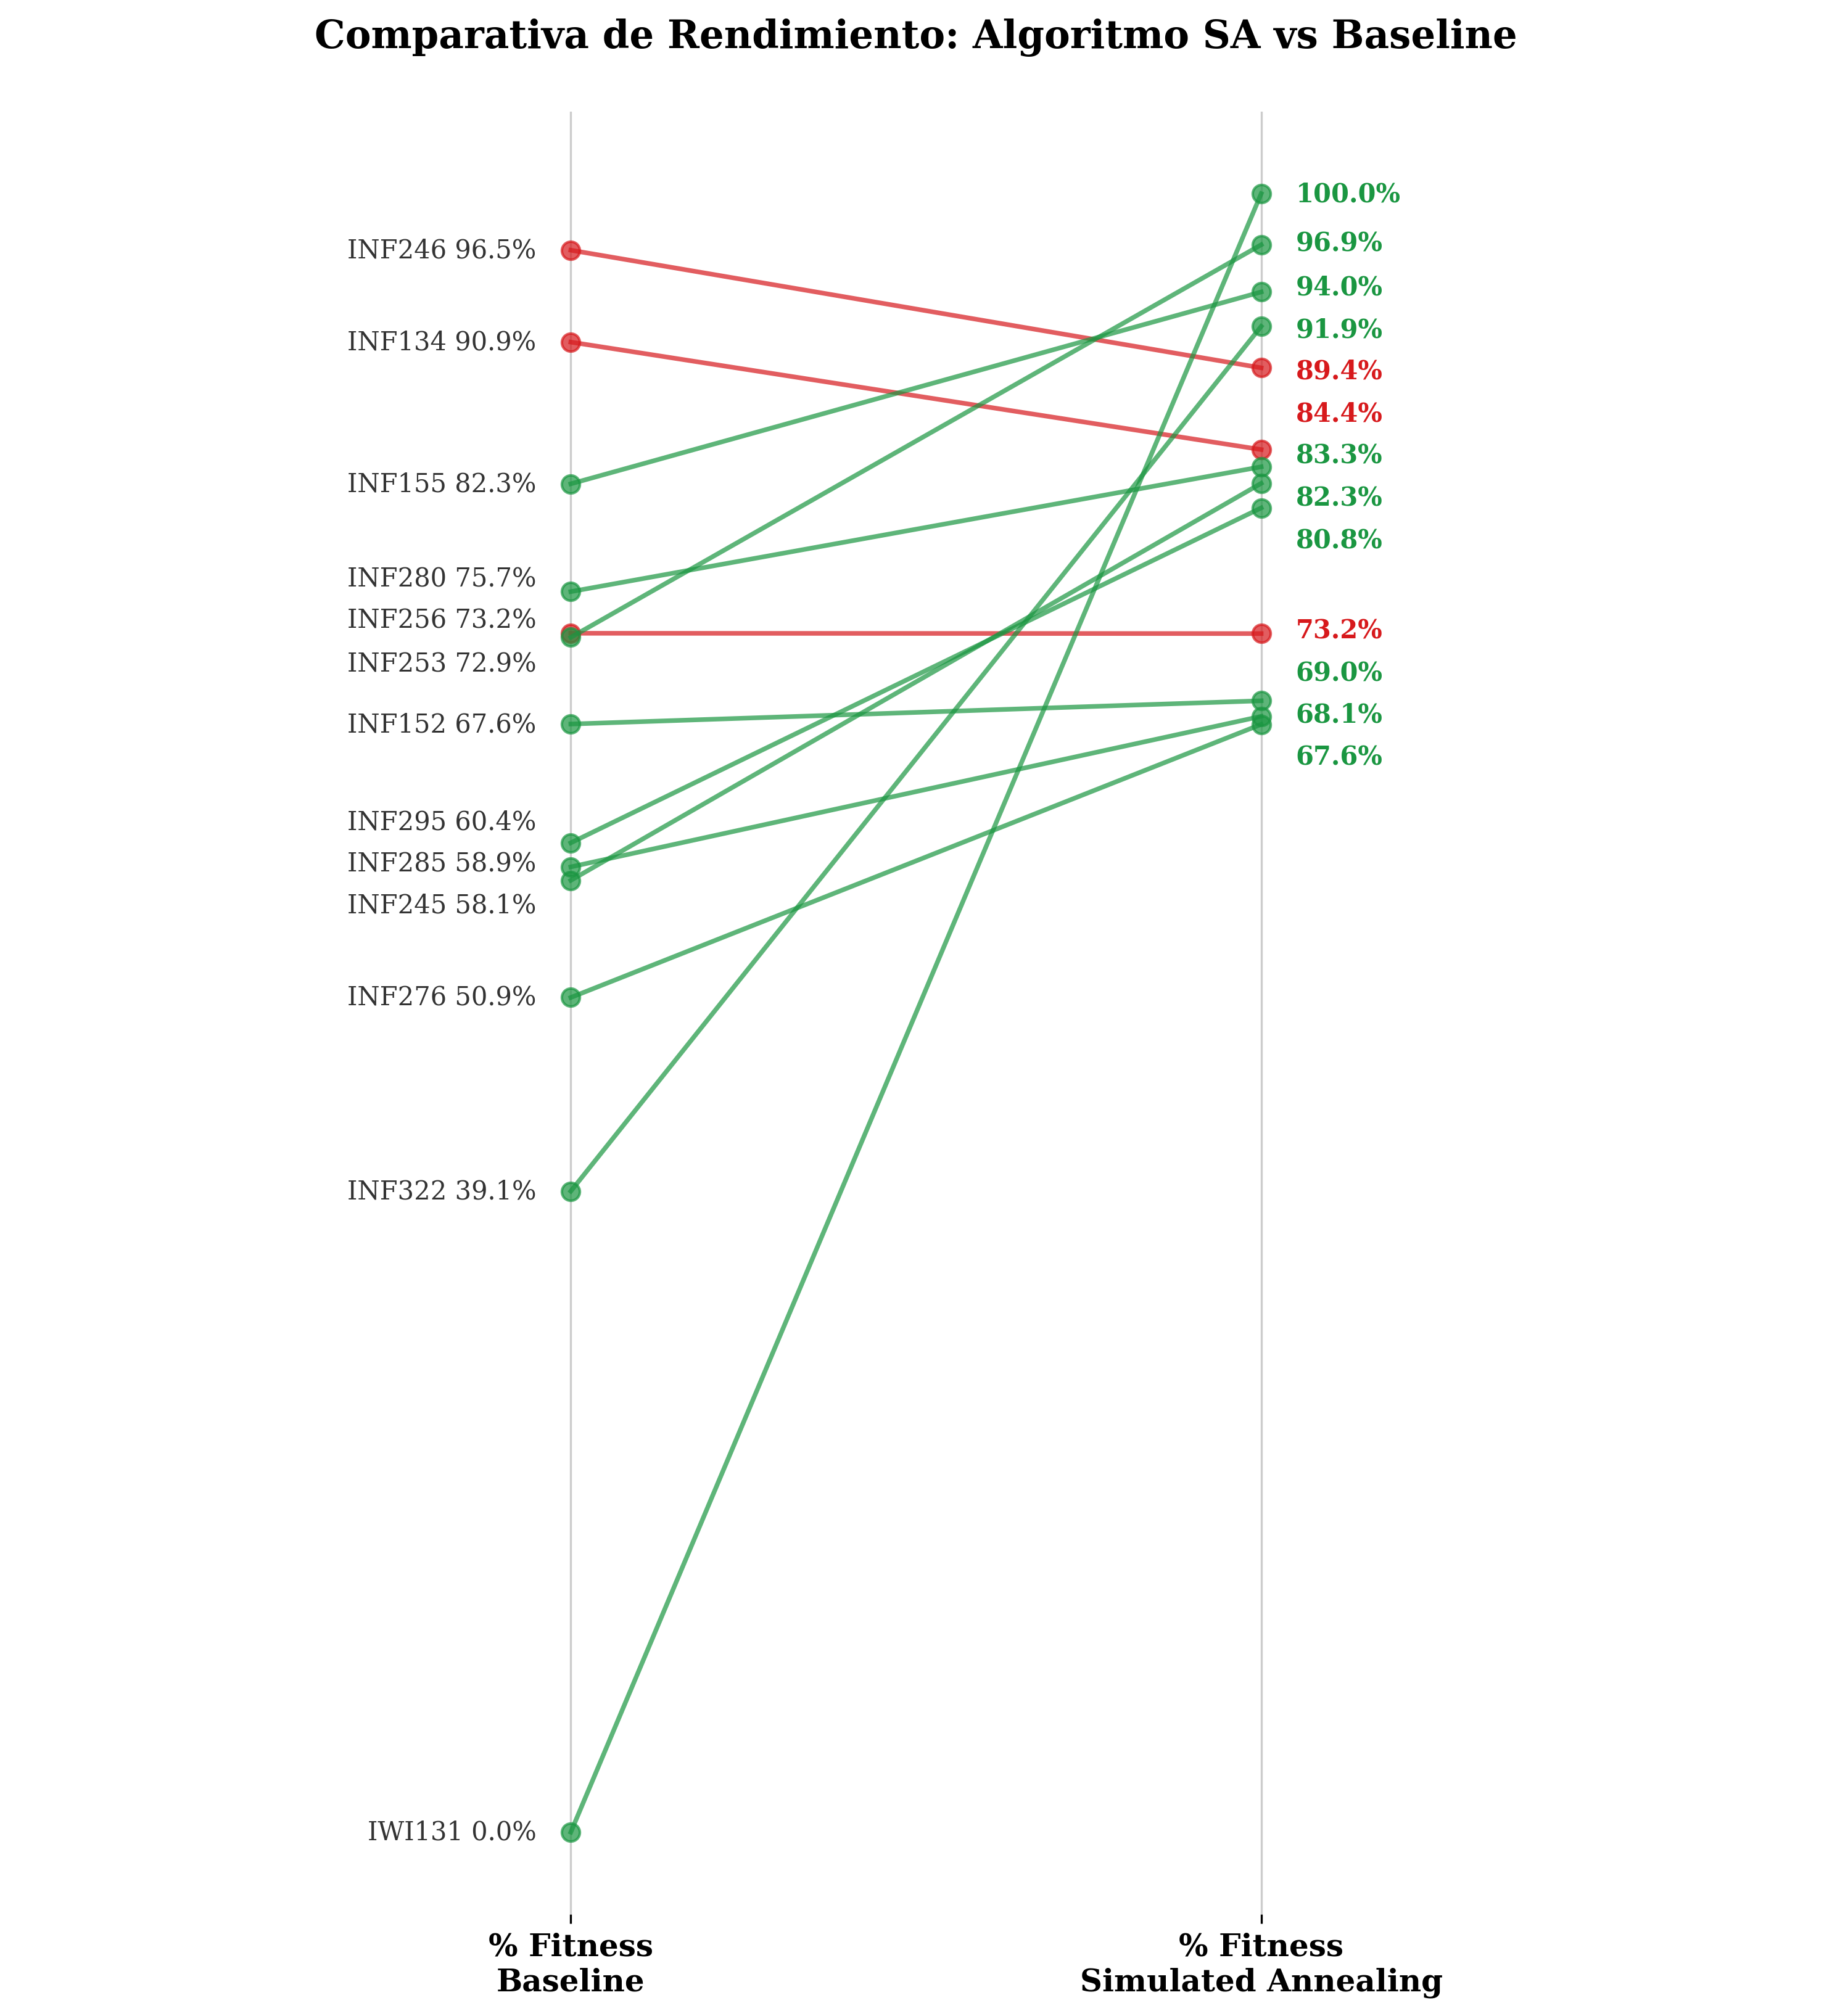

In [ ]:
# Configuración de estilo profesional
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.titlepad'] = 25

fig, ax = plt.subplots(figsize=(10, 11), dpi=300) # Mayor DPI para impresión

# Paleta de colores profesional (más sobria)
COLOR_UP = '#1a9641'   # Verde bosque
COLOR_DOWN = '#d7191c' # Rojo oscuro
COLOR_STAY = '#404040' # Gris oscuro

# Ordenar por el valor inicial ayuda a la legibilidad visual
df_comparison = df_comparison.sort_values('% Fitness Baseline', ascending=False)

# Función para evitar solapamiento (heurística simple)
def adjust_text_positions(values, min_dist=2.5):
    positions = values.copy()
    for _ in range(100): # Iteraciones para separar
        for i in range(len(positions)):
            for j in range(len(positions)):
                if i != j and abs(positions[i] - positions[j]) < min_dist:
                    if positions[i] > positions[j]:
                        positions[i] += 0.1
                        positions[j] -= 0.1
                    else:
                        positions[i] -= 0.1
                        positions[j] += 0.1
    return positions

pos_left = adjust_text_positions(df_comparison['% Fitness Baseline'].values)
pos_right = adjust_text_positions(df_comparison['% Fitness SA'].values)

# 3. Dibujar
for i, (idx, row) in enumerate(df_comparison.iterrows()):
    val_bas = row['% Fitness Baseline']
    val_sa = row['% Fitness SA']
    
    # Lógica de color
    color = COLOR_UP if val_sa > val_bas else (COLOR_DOWN if val_sa < val_bas else COLOR_STAY)
    
    # Dibujar línea y puntos
    ax.plot([0, 1], [val_bas, val_sa], color=color, marker='o', 
            markersize=7, linewidth=1.8, alpha=0.7, zorder=3)
    
    # Etiquetas Izquierda (Baseline) con posición ajustada
    ax.text(-0.05, pos_left[i], f"{row['Sigla']} {val_bas:.1f}%", 
            ha='right', va='center', fontsize=10, color='#333333')
    
    # Etiquetas Derecha (SA) con posición ajustada
    ax.text(1.05, pos_right[i], f"{val_sa:.1f}%", 
            ha='left', va='center', fontsize=10, fontweight='bold', color=color)

# 4. Estética Académica
ax.set_xlim(-0.8, 1.8)
ax.set_ylim(-5, 105)
ax.set_xticks([0, 1])
ax.set_xticklabels(['% Fitness\nBaseline', '% Fitness\nSimulated Annealing'], 
                   fontsize=12, fontweight='bold')

# Líneas verticales más sutiles
ax.axvline(0, color='black', lw=0.8, alpha=0.2, zorder=1)
ax.axvline(1, color='black', lw=0.8, alpha=0.2, zorder=1)

# Eliminar ejes
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

ax.grid(axis='y', color='gray', linestyle=':', alpha=0.2)

plt.title('Comparativa de Rendimiento: Algoritmo SA vs Baseline', 
          fontsize=15, fontweight='bold', loc='center')

plt.tight_layout()

plt.show()